In [28]:
import numpy as np

from py.simulation import *
from py.estimation import *
from py.features import *
from py.utils import *
from py.prep_data import *
from py.model import model

# visualization

from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"

cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']
from matplotlib.gridspec import GridSpec


# Data Preparation

First we read the data. In order to ensure connectedness of the endorsement matrix across many time periods, we restrict the data to only the top 100 schools by placement. 

In [29]:
rank_threshold = 5
t_start = 0

T, timesteps, labels = prep_newcomb_frat('data/newcomb_frat/', rank_threshold = rank_threshold)
T, timesteps, A0, n_obs = initial_condition(T, timesteps, t_start = t_start)

# speculative

diff = (T[10] - T[9] + T[8] - T[7])/2

for i in range(9,T.shape[0]):
    T[i] +=  diff

n = T.shape[1]

In [30]:
T.sum(axis = (1,2))

array([ 102.,  204.,  306.,  408.,  510.,  612.,  714.,  816.,  918.,
       1020., 1122., 1224., 1326., 1428., 1530., 1632.])

In [31]:
n_obs

1428.0

# Inference

Now we're ready to try to learn the model on some data. In the paper, the instantaneous rate of endorsements to $j$ is given by $\gamma_j \propto e^{\beta s_j}$. This rate is independent of the identity of the endorser. 

The model used here is an extension in two respects. First, we use a more general rate $\gamma$ that depends on the identity of both the endorser and the endorsed: 

$$\gamma_{ij} \propto e^{\beta_1s_j + \beta_2 (s_i - s_j)^2}$$

The incorporation of the quadratic term in the exponent governs a tendency for agents to endorse each other when they are nearby in the hierarchy. If $\beta_1$ is negative, endorsements that span large swaths of rank-space are discouraged. For example, in the context of faculty hiring, negative values of $-\beta_2$ would discourage cases in which a very low-ranked school was able to hire a candidate from a very high-ranked school. The model that we have been considering can be recovered by fixing $\beta_2 = 0$. 

Second, we also consider a version of this model in which, instead of $s_j$ denoting the SpringRank of $j$, we set $s_j = \sqrt{d_j}$. In this case, it doesn't matter "where" you are in the hierarchy, only the total number of endorsements you've received. 

The result of SpringRank-based inference is:

In [32]:
L_SR = model()

L_SR.set_score(
    score_function = lambda A: SpringRank.SpringRank(A.T + .0001, alpha = .01)
)

linear_feature = lambda s: np.tile(s, (n,1))

def quadratic_feature(s):
    S = linear_feature(s)
    V = (S - S.T)**2
    return(V)

L_SR.set_features([
    linear_feature, 
    quadratic_feature
])

L_SR.set_data(T, A0)

pars_SR = L_SR.ML(lam0 = .8, 
           alpha0 = 10**(-4), 
           tol = 10**(-3), 
           step_cap = .05,
           print_updates = False)
pars_SR

computing memory hyperparameter lambda
computing parameter vector beta


{'lam': 0.4460364107174428,
 'beta': array([ 1.88951531, -1.56819841]),
 'LL': -4052.6341457505414}

The result of degree-based inference is: 

In [33]:
# degree-based inference: this call should be faster

L_deg = model()

L_deg.set_score(
    score_function = lambda A: A.sum(axis = 0)
)

L_deg.set_features([
    lambda s: linear_feature(np.sqrt(s)), 
    lambda s: quadratic_feature(np.sqrt(s))
])

L_deg.set_data(T, A0)

pars_deg = L_deg.ML(lam0 = .7, 
           alpha0 = 10**(-4), 
           tol = 10**(-3), 
           step_cap = .05,
           print_updates = False)
pars_deg

computing memory hyperparameter lambda
computing parameter vector beta


{'lam': 0.6530227746545278,
 'beta': array([ 0.97023474, -0.26732704]),
 'LL': -4087.577791138897}

In [34]:
# pagerank!

L_PR = model()

def pagerank(A, alpha = 0.15, n_iter = 20): 
    n = A.shape[0]
    A = A.T/(A.T).sum(axis = 0)[:,np.newaxis]
    M = (1-alpha)*A + alpha/n
    
    v = np.random.rand(n)
    for i in range(n_iter):
        v = M.dot(v)
    return(v/v.sum())
    
L_PR.set_score(
    score_function = pagerank
)

L_PR.set_features([
    linear_feature, 
    quadratic_feature
])

L_PR.set_data(T, A0)

pars_PR = L_PR.ML(lam0 = .2, 
           alpha0 = 10**(-2), 
           tol = 10**(-5), 
           step_cap = .1,
           print_updates = False)
pars_PR

computing memory hyperparameter lambda
computing parameter vector beta


{'lam': 0.3612126292911853,
 'beta': array([  18.64044379, -134.85944995]),
 'LL': -4077.1689824906316}

In [35]:
L_L = model()

def fiedler_vector(A):
    A = (A + A.T)/2 + .01
    D = np.diag(A.sum(axis = 1))
    L = D - A
    eig = np.linalg.eigh(L)
    v = eig[1][:,1]
    if v[0] < 0:
        v = -v
    return(v)

L_L.set_score(
    score_function = fiedler_vector
)

L_L.set_features([
    lambda s: linear_feature(s), 
    lambda s: quadratic_feature(s)
])

L_L.set_data(T, A0)

pars_L = L_L.ML(lam0 = .9, 
           alpha0 = 10**(-2), 
           tol = 10**(-3), 
           step_cap = .1,
           print_updates = False)
pars_L

computing memory hyperparameter lambda
computing parameter vector beta


{'lam': 0.7806888259399785,
 'beta': array([ 0.82004246, -7.97804203]),
 'LL': -3976.3311079721616}

In [36]:
L_K = model()

# @jit(nopython=True)
def katz_score(A, alpha = .001):
    n = A.shape[0]
    e = np.ones(n)
    I = np.eye(n,n)
    return(np.linalg.inv(I - alpha*A).dot(e))

L_K.set_score(
    score_function = lambda A: katz_score(A.T, alpha = .1)
)

L_K.set_features([
    lambda s: linear_feature(s), 
    lambda s: quadratic_feature(s)
])

L_K.set_data(T, A0)

pars_K = L_K.ML(lam0 = 0.5, 
           alpha0 = 10**(-2), 
           tol = 10**(-6), 
           step_cap = .1,
           print_updates = True)
pars_K

computing memory hyperparameter lambda
Lambda = 0.441795732911487, LL = 4082.449923076557
Lambda = 0.41415001045425015, LL = 4082.3922727374697
Lambda = 0.3999380990426289, LL = 4082.376870866793
Lambda = 0.3924042168255255, LL = 4082.372526683136
Lambda = 0.3883530794955732, LL = 4082.371271328599
Lambda = 0.3861590443539171, LL = 4082.3709048602923
Lambda = 0.384966338686354, LL = 4082.3707977142603
Lambda = 0.3843166756159917, LL = 4082.3707665824977
Lambda = 0.38396242624730803, LL = 4082.3707576895004
Lambda = 0.3837691479820933, LL = 4082.370755241259
Lambda = 0.3836636620126228, LL = 4082.370754620719
computing parameter vector beta


{'lam': 0.3836636620126228,
 'beta': array([ 0.6879737 , -0.15812875]),
 'LL': -4082.370754620719}

In [37]:
# batch standard errors

d = {
    'SR': [L_SR, pars_SR],
    'deg': [L_deg, pars_deg], 
    'PR': [L_PR, pars_PR], 
    'L' : [L_L, pars_L]
}

for key in d: 
    L = d[key][0]
    pars = d[key][1]
    H = L.estimate_hessian(pars['lam'], pars['beta'])
    V = np.linalg.inv(-H) # covariance matrix
    print(key + ': ' + str(np.round(np.sqrt(np.diag(V)), 3)))

SR: [0.158 0.114 0.141]
deg: [0.118 0.052 0.035]
PR: [ 0.177  0.957 12.901]
L: [0.063 0.146 0.4  ]


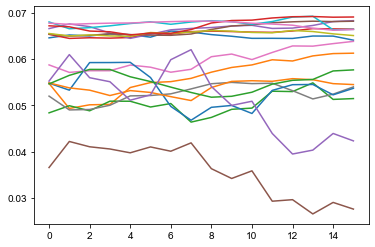

In [57]:
est = plt.plot(L_L.get_rates().mean(axis = 1))
# est = plt.plot(L_L.get_scores())

Let's proceed with the SR-based parameters. 

In [39]:
pars = pars_L
L = L_L

# Parameter Uncertainty

Now let's estimate the covariance matrix of the parameters by inverting the Hessian matrix of the likelihood function at the parameters we solved for. 

In [40]:
# again might take a little while

H = L.estimate_hessian(pars['lam'], pars['beta'])
V = np.linalg.inv(-H) # covariance matrix
np.sqrt(np.diag(V))

array([0.06318879, 0.14646316, 0.39966783])

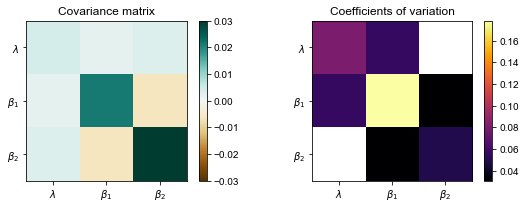

In [41]:
fig = plt.figure(figsize = (8, 3))
ax = fig.add_subplot(121)
im = ax.imshow(V, cmap = 'BrBG', vmin = -0.03, vmax = 0.03) # estimated covariance matrix
plt.colorbar(im)
t = ax.set_title('Covariance matrix')
plt.xticks([0,1,2], [r'$\lambda$', r'$\beta_1$', r'$\beta_2$'])
plt.yticks([0,1,2], [r'$\lambda$', r'$\beta_1$', r'$\beta_2$'])

ax = fig.add_subplot(122)
p = np.concatenate(([pars['lam']], pars['beta']))
im = ax.imshow(np.sqrt(V/np.outer(p,p)), cmap = 'inferno')    # coefficient of variation
plt.colorbar(im)

plt.xticks([0,1,2], [r'$\lambda$', r'$\beta_1$', r'$\beta_2$'])
plt.yticks([0,1,2], [r'$\lambda$', r'$\beta_1$', r'$\beta_2$'])

t = ax.set_title('Coefficients of variation')

plt.tight_layout()

plt.savefig('fig/frat_cv.png', dpi = 300)

# Snapshot of model prediction

The mini-study below considers how the model ''works.'' 

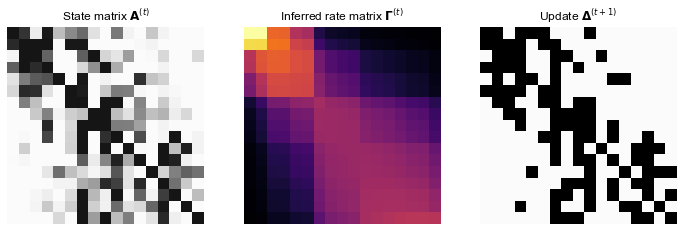

In [64]:
# snapshot of the state and cumulative hiring matrix at specified time i

# A = state_matrix(T, A0 = A0, lam = pars['lam'])

# S = SR_quadratic_feature(A)

i = 2



V = L.GAMMA[i]
# V = softmax(S, np.array([2.8, 0]))[i]

fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot(131)
ax.imshow(np.ones_like(V), cmap = 'Greys', vmax = 1, vmin = 0, alpha = 1)

sorter = -fiedler_vector(L.A[i])

ax.imshow(matrix_sort(L.A[i], sorter), vmax = 1,  cmap = 'Greys', alpha = .99)
ax.set(title = r'State matrix $\mathbf{A}^{(t)}$')
ax.axis('off')

ax = fig.add_subplot(132)
# plt.imshow(np.ones_like(V), cmap = 'Greys', vmax = 1)
ax.imshow(matrix_sort(V, sorter), alpha = .995, cmap = 'inferno', vmax = .2)
ax.set(title = 'Inferred rate matrix $\mathbf{\Gamma}^{(t)}$')
plt.gca().axis('off')

ax = fig.add_subplot(133)
ax.imshow(np.ones_like(T[i]), cmap = 'Greys', vmax = 1, vmin = 0, alpha = 1)
ax.imshow(matrix_sort(T[i+1]-T[i], sorter), vmax = 1,  cmap = 'Greys', alpha = .99)
ax.set(title = 'Update $\mathbf{\Delta}^{(t+1)}$')
ax.axis('off')
# plt.colorbar()

plt.savefig('fig/frat_illustration.png', dpi = 300, bbox_inches = 'tight')

On the far left, we show the model state $A_t$ at time $t = 30$. Each entry of this matrix is a weighted sum of previous hiring events: $A_{ij}^{(t)} = \sum_{\tau = 1}^t \lambda^\tau E_{ij}^{(\tau)}$, where $E_{ij}^{(\tau)}$ is the number of times $i$ endorsed $j$ in time period $\tau$. This matrix is an input into the rate matrix $\Gamma$, which is shown in the center. This is a matrix of predictions about endorsements in the next time-step: entry $\gamma_{ij}$ is proportional to the predicted probability that $i$ will endorse $j$ in the next timestep. Finally, we can (heuristically) compare the rate matrix to the observed update at time $t+1$, noting that the bulk of endorsement events do indeed occur in regions of high probability specified by the rate matrix. 

# Inferred rank dynamics

Now let's visualize the evolution of this system as understood by the model. It's of possible interest to visualize at least two distinct objects. The first is the overall modeled endorsement rate, which predicts the rate of endorsements of $j$ in the next timestep. The second is the intrinsic ranks modeled for each individual school. 

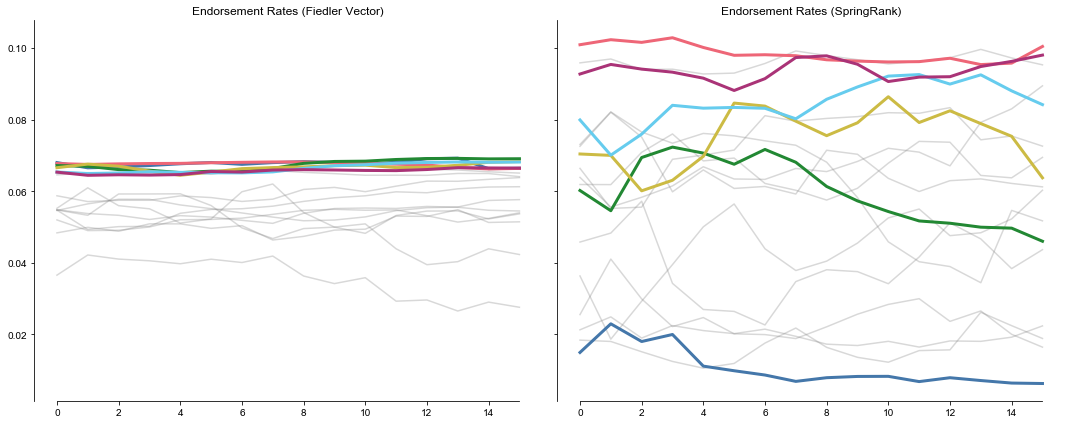

In [53]:
fig, axarr = plt.subplots(1, 2, figsize = (15,6), sharey = True)

# FIRST PLOT

ax = axarr[0]

# A = state_matrix(T, A0 = A0, lam = pars['lam'])
# S = feature_fun(A)

GAMMA = L_L.GAMMA.mean(axis = 1)

top_trajectories = np.unique(GAMMA.argmax(axis = 1))
top_trajectories = (-GAMMA.mean(axis = 0)).argsort()[0:6]


# for i in range(6, top_n):
p = ax.plot(timesteps, GAMMA, color = 'grey', alpha = .3)

k = 0
for i in top_trajectories:
    ax.plot(timesteps, GAMMA[:,i], color = cset[k], alpha = 1, linewidth = 3)
    k += 1

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.spines['bottom'].set_bounds(timesteps.min(), timesteps.max())

ax.set(title = 'Endorsement Rates (Fiedler Vector)')


# SECOND PLOT

ax = axarr[1]

GAMMA = L_SR.GAMMA.mean(axis = 1)

# top_trajectories = np.unique(GAMMA.argmax(axis = 1))
# top_trajectories = (-GAMMA.mean(axis = 0)).argsort()[0:6]

# GAMMA = np.sort(GAMMA, axis = 1)
# for i in range(6, top_n):
p = ax.plot(timesteps, GAMMA, color = 'grey', alpha = .3)

k = 0
for i in top_trajectories:
    ax.plot(timesteps, GAMMA[:,i], color = cset[k], alpha = 1, linewidth = 3)
    k += 1

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.spines['left'].set_bounds(0, GAMMA.max())
ax.spines['bottom'].set_bounds(timesteps.min(), timesteps.max())

ax.set(title = 'Endorsement Rates (SpringRank)')

plt.tight_layout()

plt.savefig('fig/frat_ranks.png', dpi = 300)

These two figures tell an interesting story. On the left, the endorsement rate is proportional to the modeled rate at which a given school will be endorsed (i.e. place a candidate) in the next timestep. There is considerable heterogeneity in the ranks, as we would expect. 

If we look over to the right, however, we see much stronger inequality. That's because the righthand side has controlled for peer-effects, and is estimating pure prestige scores without regard for what schools are nearby in the rankings. These scores are more directly interpretable as pure measures of the prestige of each school. 

Mathematically, the endorsement rate on the righthand side is given by the expression $\gamma_j = \sum_{i} \gamma_{ij}$ where 

$$\gamma_{ij} \propto e^{\beta_1s_j + \beta_2 (s_i - s_j)^2}$$

as before. The inferred ranks are 

$$r_j \propto e^{\beta_1s_j}\;.$$